In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.8/882.8 kB 14.3 MB/s eta 0:00:00


In [ ]:
pip install --upgrade git+https://github.com/ultralytics/yolov8.git


  Cloning https://github.com/ultralytics/yolov8.git to /tmp/pip-req-build-uibp_pnd
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/yolov8.git /tmp/pip-req-build-uibp_pnd
  fatal: could not read Username for 'https://github.com': No such device or address
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/ultralytics/yolov8.git /tmp/pip-req-build-uibp_pnd did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/ultralytics/yolov8.git /tmp/pip-req-build-uibp_pnd did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import torch
import cv2
from PIL import Image
import numpy as np
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow

YOLO Classes: {0: 'elbow positive', 1: 'fingers positive', 2: 'forearm fracture', 3: 'humerus fracture', 4: 'humerus', 5: 'shoulder fracture', 6: 'wrist positive'}

0: 640x544 1 humerus, 17.7ms
Speed: 3.8ms preprocess, 17.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 544)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Detected Fracture Type: mosquito_net with confidence 0.91


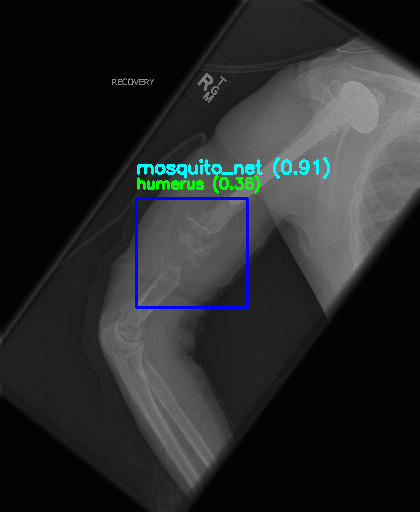

In [ ]:
import torch
import cv2
from PIL import Image
import numpy as np
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow  # For displaying images in Colab
import tensorflow as tf
# Load YOLOv10 model using custom weights
from ultralytics import YOLO
from tensorflow.keras.models import load_model

dirnameYolo = "/content/drive/MyDrive/bone fracture detection1/best20.pt"  # Your custom YOLO model path
yolo_model = YOLO(dirnameYolo)

# Get class names for the YOLO model
class_list = yolo_model.model.names
print("YOLO Classes:", class_list)

# Load ResNet152V2 model for classification
resnet_model = ResNet152V2(weights='imagenet')  # You can replace with custom weights if available





# Function to detect tumors using YOLOv10
def detect_tumor(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB to avoid channel issues
    results = yolo_model(image)  # Run inference

    # Extract bounding boxes, scores, and classes
    detections = []
    for box in results[0].boxes:  # Loop through each box
        x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()  # Confidence score
        cls = box.cls[0].cpu().numpy()  # Class label (index)
        detections.append((x_min, y_min, x_max, y_max, conf, cls))

    return np.array(detections), np.array(image)

# Function to classify the tumor region using ResNet152V2
def classify_tumor_region(img_array):
    img = Image.fromarray(img_array)  # Convert array back to PIL image for resizing
    img = img.resize((224, 224))  # Resize to ResNet input size
    img = keras_image.img_to_array(img)  # Convert to NumPy array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Preprocess for ResNet model

    # Predict the class using ResNet152V2
    predictions = resnet_model.predict(img)
    return decode_predictions(predictions, top=1)[0]  # Get top-1 prediction

# Function to visualize detection results
def visualize_detections(image, detections):
    for det in detections:
        x_min, y_min, x_max, y_max, conf, cls = det  # Unpack detection
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])  # Convert to int

        # Draw rectangle around detected region
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        # Annotate the detection with confidence score and class label
        label = f'{class_list[int(cls)]} ({conf:.2f})'  # Get class name from index
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display image in Colab
    cv2_imshow(image)
    cv2.waitKey(0)

# Main function to process the MRI image
def process_image(image_path):
    detections, original_image = detect_tumor(image_path)  # Detect tumors using YOLOv10

    # Loop through detected regions and classify each
    for det in detections:
        x_min, y_min, x_max, y_max = map(int, det[:4])
        cropped_region = original_image[y_min:y_max, x_min:x_max]  # Crop detected region

        # Classify the cropped region using ResNet152V2
        tumor_type = classify_tumor_region(cropped_region)
        print(f"Detected Fracture Type: {tumor_type[0][1]} with confidence {tumor_type[0][2]:.2f}")

        # Annotate the classification result on the image
        cv2.putText(original_image, f'{tumor_type[0][1]} ({tumor_type[0][2]:.2f})',
                    (x_min, y_min - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    # Visualize the final results with annotations
    visualize_detections(original_image, detections)

# Example usage
image_path = '/content/drive/MyDrive/bone fracture detection1/extracted dataset/BoneFractureYolo8/train/images/image2_535_png.rf.9f41f774922b827032200a54ddc7ad52.jpg'
process_image(image_path)


YOLO Classes: {0: 'elbow positive', 1: 'fingers positive', 2: 'forearm fracture', 3: 'humerus fracture', 4: 'humerus', 5: 'shoulder fracture', 6: 'wrist positive'}

0: 640x544 1 humerus, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)
Detected Fracture Type: 5


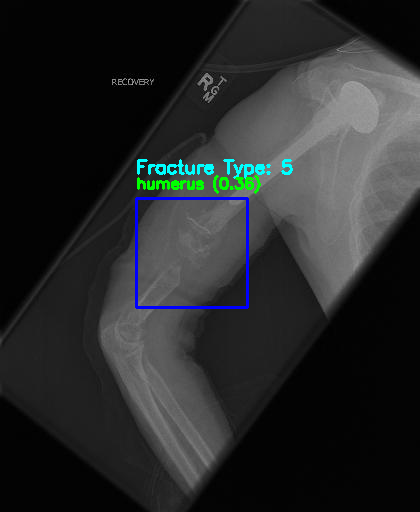

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from ultralytics import YOLO
import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Load YOLOv10 model using custom weights
dirnameYolo = "/content/drive/MyDrive/bone fracture detection1/best20.pt"  # Your custom YOLO model path
yolo_model = YOLO(dirnameYolo)

# Get class names for the YOLO model
class_list = yolo_model.model.names
print("YOLO Classes:", class_list)

# Define ResNet32 model (as previously defined)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=7):  # Change num_classes based on your use case
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet32(num_classes=7):  # Change num_classes based on your use case
    return ResNet(BasicBlock, [5, 5, 5], num_classes)

# Load ResNet32 model
resnet_model = resnet32(num_classes=7)  # Match num_classes to your classification needs
model_path = '/content/drive/MyDrive/bone fracture detection1/models/classification_model.pth'  # Replace with your actual model path

# Load weights with error handling
try:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    resnet_model.load_state_dict(state_dict, strict=False)  # Allow missing keys
    resnet_model.eval()  # Set model to evaluation mode
except RuntimeError as e:
    print(f"Error loading model: {e}")

# Define the image transformation for ResNet32
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

# Function to detect tumors using YOLOv10
def detect_tumor(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    results = yolo_model(image)  # Run inference

    # Extract bounding boxes, scores, and classes
    detections = []
    for box in results[0].boxes:  # Loop through each box
        x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()  # Confidence score
        cls = box.cls[0].cpu().numpy()  # Class label (index)
        detections.append((x_min, y_min, x_max, y_max, conf, cls))

    return np.array(detections), np.array(image)

# Function to classify the tumor region using ResNet32
def classify_tumor_region(img_array):
    img = Image.fromarray(img_array)  # Convert array back to PIL image for resizing
    img = transform(img)  # Apply transformations
    img = img.unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        outputs = resnet_model(img)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    return predicted.item()  # Return predicted class index

# Function to visualize detection results
def visualize_detections(image, detections):
    for det in detections:
        x_min, y_min, x_max, y_max, conf, cls = det  # Unpack detection
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])  # Convert to int

        # Draw rectangle around detected region
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        # Annotate the detection with confidence score and class label
        label = f'{class_list[int(cls)]} ({conf:.2f})'  # Get class name from index
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display image in Colab
    cv2_imshow(image)

# Main function to process the MRI image
def process_image(image_path):
    detections, original_image = detect_tumor(image_path)  # Detect tumors using YOLOv10

    # Loop through detected regions and classify each
    for det in detections:
        x_min, y_min, x_max, y_max = map(int, det[:4])
        cropped_region = original_image[y_min:y_max, x_min:x_max]  # Crop detected region

        # Classify the cropped region using ResNet32
        tumor_type = classify_tumor_region(cropped_region)
        print(f"Detected Fracture Type: {tumor_type}")

        # Annotate the classification result on the image
        cv2.putText(original_image, f'Fracture Type: {tumor_type}',
                    (x_min, y_min - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    # Visualize the final results with annotations
    visualize_detections(original_image, detections)

# Example usage
image_path = '/content/drive/MyDrive/bone fracture detection1/extracted dataset/BoneFractureYolo8/train/images/image2_535_png.rf.9f41f774922b827032200a54ddc7ad52.jpg'
process_image(image_path)


YOLO Classes: {0: 'elbow positive', 1: 'fingers positive', 2: 'forearm fracture', 3: 'humerus fracture', 4: 'humerus', 5: 'shoulder fracture', 6: 'wrist positive'}

0: 640x512 1 shoulder fracture, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)
Detected Fracture Type: shoulder fracture


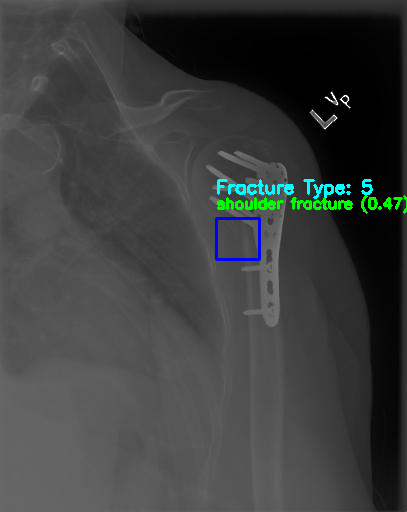

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from ultralytics import YOLO
import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Load YOLOv10 model using custom weights
dirnameYolo = "/content/drive/MyDrive/bone fracture detection1/best20.pt"  # Your custom YOLO model path
yolo_model = YOLO(dirnameYolo)

# Get class names for the YOLO model
class_list = yolo_model.model.names
print("YOLO Classes:", class_list)

# Define ResNet32 model (as previously defined)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=7):  # Change num_classes based on your use case
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet32(num_classes=7):  # Change num_classes based on your use case
    return ResNet(BasicBlock, [5, 5, 5], num_classes)

# Load ResNet32 model
resnet_model = resnet32(num_classes=7)  # Match num_classes to your classification needs
model_path = '/content/drive/MyDrive/bone fracture detection1/models/classification_model.pth'  # Replace with your actual model path

# Load weights with error handling
try:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    resnet_model.load_state_dict(state_dict, strict=False)  # Allow missing keys
    resnet_model.eval()  # Set model to evaluation mode
except RuntimeError as e:
    print(f"Error loading model: {e}")

# Define the image transformation for ResNet32
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

# Function to detect tumors using YOLOv10
def detect_tumor(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    results = yolo_model(image)  # Run inference

    # Extract bounding boxes, scores, and classes
    detections = []
    for box in results[0].boxes:  # Loop through each box
        x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()  # Confidence score
        cls = box.cls[0].cpu().numpy()  # Class label (index)
        detections.append((x_min, y_min, x_max, y_max, conf, cls))

    return np.array(detections), np.array(image)

# Function to classify the tumor region using ResNet32
def classify_tumor_region(img_array):
    img = Image.fromarray(img_array)  # Convert array back to PIL image for resizing
    img = transform(img)  # Apply transformations
    img = img.unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        outputs = resnet_model(img)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    return predicted.item()  # Return predicted class index

# Function to visualize detection results
def visualize_detections(image, detections):
    for det in detections:
        x_min, y_min, x_max, y_max, conf, cls = det  # Unpack detection
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])  # Convert to int

        # Draw rectangle around detected region
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        # Annotate the detection with confidence score and class label
        label = f'{class_list[int(cls)]} ({conf:.2f})'  # Get class name from index
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display image in Colab
    cv2_imshow(image)
class_mapping = {
    0: 'elbow positive',
    1: 'fingers positive',
    2: 'forearm fracture',
    3: 'humerus fracture',
    4: 'humerus',
    5: 'shoulder fracture',
    6: 'wrist positive'
}
# Main function to process the MRI image
def process_image(image_path):
    detections, original_image = detect_tumor(image_path)  # Detect tumors using YOLOv10

    # Loop through detected regions and classify each
    for det in detections:
        x_min, y_min, x_max, y_max = map(int, det[:4])
        cropped_region = original_image[y_min:y_max, x_min:x_max]  # Crop detected region

        # Classify the cropped region using ResNet32
        tumor_type = classify_tumor_region(cropped_region)
        tumor_type_name = class_mapping.get(tumor_type, "Unknown")
        print(f"Detected Fracture Type: {tumor_type_name}")

        # Annotate the classification result on the image
        cv2.putText(original_image, f'Fracture Type: {tumor_type}',
                    (x_min, y_min - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    # Visualize the final results with annotations
    visualize_detections(original_image, detections)

# Example usage
image_path = '/content/drive/MyDrive/bone fracture detection1/extracted dataset/BoneFractureYolo8/test/images/image1_3368_png.rf.074f5f9364ab5534a1e1285ad13e5e0b.jpg'
process_image(image_path)


YOLO Classes: {0: 'elbow positive', 1: 'fingers positive', 2: 'forearm fracture', 3: 'humerus fracture', 4: 'humerus', 5: 'shoulder fracture', 6: 'wrist positive'}

0: 640x512 1 shoulder fracture, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)
Detected Fracture Type: shoulder fracture


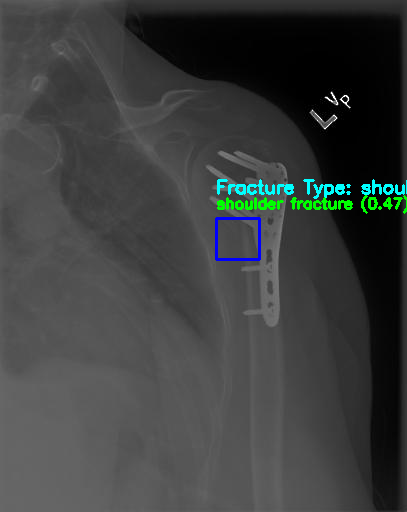

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from ultralytics import YOLO
import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Load YOLOv10 model using custom weights
dirnameYolo = "/content/drive/MyDrive/bone fracture detection1/best20.pt"  # Your custom YOLO model path
yolo_model = YOLO(dirnameYolo)

# Get class names for the YOLO model
class_list = yolo_model.model.names
print("YOLO Classes:", class_list)

# Define ResNet32 model (as previously defined)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=7):  # Change num_classes based on your use case
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet32(num_classes=7):  # Change num_classes based on your use case
    return ResNet(BasicBlock, [5, 5, 5], num_classes)

# Load ResNet32 model
resnet_model = resnet32(num_classes=7)  # Match num_classes to your classification needs
model_path = '/content/drive/MyDrive/bone fracture detection1/models/classification_model.pth'  # Replace with your actual model path

# Load weights with error handling
try:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    resnet_model.load_state_dict(state_dict, strict=False)  # Allow missing keys
    resnet_model.eval()  # Set model to evaluation mode
except RuntimeError as e:
    print(f"Error loading model: {e}")

# Define the image transformation for ResNet32
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

# Function to detect fractures using YOLOv10
def detect_fracture(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    results = yolo_model(image)  # Run inference

    # Extract bounding boxes, scores, and classes
    detections = []
    for box in results[0].boxes:  # Loop through each box
        x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()  # Confidence score
        cls = box.cls[0].cpu().numpy()  # Class label (index)
        detections.append((x_min, y_min, x_max, y_max, conf, cls))

    return np.array(detections), np.array(image)

# Function to classify the fracture region using ResNet32
def classify_fracture_region(img_array):
    img = Image.fromarray(img_array)  # Convert array back to PIL image for resizing
    img = transform(img)  # Apply transformations
    img = img.unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        outputs = resnet_model(img)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    return predicted.item()  # Return predicted class index

# Function to visualize detection results
def visualize_detections(image, detections):
    for det in detections:
        x_min, y_min, x_max, y_max, conf, cls = det  # Unpack detection
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])  # Convert to int

        # Draw rectangle around detected region
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        # Annotate the detection with confidence score and class label
        label = f'{class_list[int(cls)]} ({conf:.2f})'  # Get class name from index
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display image in Colab
    cv2_imshow(image)

class_mapping = {
    0: 'elbow positive',
    1: 'fingers positive',
    2: 'forearm fracture',
    3: 'humerus fracture',
    4: 'humerus',
    5: 'shoulder fracture',
    6: 'wrist positive'
}

# Main function to process the MRI image
def process_image(image_path):
    detections, original_image = detect_fracture(image_path)  # Detect fractures using YOLOv10

    # Loop through detected regions and classify each
    for det in detections:
        x_min, y_min, x_max, y_max = map(int, det[:4])
        cropped_region = original_image[y_min:y_max, x_min:x_max]  # Crop detected region

        # Classify the cropped region using ResNet32
        fracture_type = classify_fracture_region(cropped_region)
        fracture_type_name = class_mapping.get(fracture_type, "Unknown")
        print(f"Detected Fracture Type: {fracture_type_name}")

        # Annotate the classification result on the image
        cv2.putText(original_image, f'Fracture Type: {fracture_type_name}',
                    (x_min, y_min - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    # Visualize the final results with annotations
    visualize_detections(original_image, detections)

# Example usage
image_path = '/content/drive/MyDrive/bone fracture detection1/extracted dataset/BoneFractureYolo8/test/images/image1_3368_png.rf.074f5f9364ab5534a1e1285ad13e5e0b.jpg'
process_image(image_path)
